In [1]:
import logging
import os

import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
from matplotlib import pyplot as plt
from skimage import img_as_ubyte, color, feature, exposure
from sklearn.model_selection import train_test_split
from torch.utils import data
from torchvision import datasets
from tqdm import tqdm

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

    
import torch.optim as optim

from torch import nn
import torch.nn.functional as F

In [2]:
from cnn import EmotionRecCNN
from mlp import EmotionRecMLP
from matplotlib import pyplot as plt
import logging
import os
from pathlib import Path
import joblib
from sklearn import metrics
from PIL import Image
import numpy as np
import random
import cv2
import torch
from config import LABELS
from tqdm import tqdm

from collections import OrderedDict

from utils import load_data, plot_sample_predictions, get_pred_metrics

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

PROJECT_DIR = Path(os.path.dirname(os.path.abspath('.'))).parent.absolute()
DATASET_DIR = str(PROJECT_DIR.joinpath("cw_dataset"))
MODELS_DIR = str(PROJECT_DIR.joinpath("models"))
VIDEOS_DIR = str(PROJECT_DIR.joinpath("video"))

SVM_MODEL = "SIFT-SVC_2021-04-13 05-23.joblib"
CNN_MODEL = "CNN_2021-04-29 10-11.pth"
MLP_MODEL = "MLP_2021-04-12 19-52.pth"

MLP_INPUT = 14112  # length of hog feature descriptors
MLP_HOG_DICT = {"orientation": 8, "pix_per_cell": (6, 6)}

In [3]:
import logging
import os
import random
from pprint import pformat

import cv2
import matplotlib as mpl
import numpy as np
import seaborn as sns
import torch
import torch.nn.functional as F
from config import LABELS, PLOT_RC
from matplotlib import pyplot as plt
from skimage import color, feature, img_as_ubyte
from sklearn import metrics
from sklearn.cluster import MiniBatchKMeans
from torch import nn
from torch.utils import data
from torch.utils.tensorboard import SummaryWriter
from torch.utils.tensorboard.summary import hparams
from torchvision import datasets, transforms
from tqdm import tqdm
import warnings

In [4]:
sns.set()
sns.set_style(rc=PLOT_RC)
sns.set_context("notebook", font_scale=0.9)
mpl.rcParams["figure.edgecolor"] = "black"
mpl.rcParams["axes.linewidth"] = 0.5

In [2]:


# face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# img = cv2.imread('WIN_20201209_17_25_54_Pro.jpg')
# gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# faces = face_cascade.detectMultiScale(gray, 1.3, 5)
# for (x,y,w,h) in faces:
#     img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
#     roi_gray = gray[y:y+h, x:x+w]
#     roi_color = img[y:y+h, x:x+w]

# cv2.imshow('img',img)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

In [2]:
class HOG:
    def __init__(self, orientations, pix_per_cell, cells_per_block, multichannel):
        self.orientations = orientations
        self.pix_per_cell = pix_per_cell
        self.cells_per_block = cells_per_block
        self.multichannel = multichannel

    def fit(self, X):
        return self

    def transform(self, X):
        hog_arr = list()

        logger.info(f"Beginning HOG transformations for {len(X)} images")
        for i in tqdm(range(len(X))):
            img = img_as_ubyte(color.rgb2gray(X[i]))
            HOG_des = feature.hog(
                img,
                orientations=self.orientations,
                pixels_per_cell=self.pix_per_cell,
                cells_per_block=self.cells_per_block,
                feature_vector=True,
                multichannel=False
            )
            hog_arr.append(HOG_des)
        return hog_arr

    def fit_transform(self, X):
        return self.fit(X).transform(X)

    def __call__(self, x):
        HOG_des = feature.hog(
            x,
            orientations=self.orientations,
            pixels_per_cell=self.pix_per_cell,
            cells_per_block=self.cells_per_block,
            feature_vector=True,
            multichannel=True
        )
        return HOG_des

In [3]:
def load_data(
    path,
    subset,
    method,
    hog_dict,
    batch_size,
    shuffle=True,
    drop_last=False,
    weight_samp=False,
    num_images=None,
):
    """
    Function to dynamically load and preprocess images depending on the data subset (train/test/valid)
    as well as the pre-processing methods (SIFT, HOG, CNN).

    Args:
        path (str): Directory containing image files.
        subset (str): String e.g. "train" or "test".
        method (str): Type of pre-processing strategy e.g. "hog", "sift", "svm".
        hog_dict (dict): Dictionary containing hyperparameters for HOG feature extraction.
        batch_size (int or None): Training batch size for DataLoader processing methods.
        shuffle (bool): Indicates whether the returned DataLodaer will shuffle every batch
        drop_last (bool): Indicates whether or not the last incomplete batch should be discarded or not
        weight_samp (bool): Indicates if random weighted sampling should be applied to DataLoader

    Returns: (DataLoader or tuple) Preprocessed dataset

    """
    if not os.path.exists(path):
        logger.info("Please download training/testing data to cw_dataset directory")
        return None

    # create a string identifier with the data subset and model type
    key = subset + "_" + method

    # define the image augmentation transforms
    augmentation_transforms = [
        transforms.ColorJitter(0.50, 0.50, 0.1, 0.1),
        transforms.GaussianBlur(3, (0.001, 1)),
        transforms.RandomGrayscale(p=0.5),
        transforms.RandomHorizontalFlip(),
        transforms.RandomAffine(15, scale=(0.75, 1.25)),
        transforms.ToTensor(),
        transforms.RandomErasing(p=0.50),
        transforms.ToPILImage(),
    ]

    transform_dict = {
        # the training transforms contain data augmentation
        "train_hog": transforms.Compose(
            [
                *augmentation_transforms,
                HOG(
                    orientations=hog_dict.get("orientation"),
                    pix_per_cell=hog_dict.get("pix_per_cell"),
                    cells_per_block=(1, 1),
                    multichannel=True,
                ),
            ]
        ),
        # validation/test transforms do not have data augmentation
        "val_hog": transforms.Compose(
            [
                HOG(
                    orientations=hog_dict.get("orientation"),
                    pix_per_cell=hog_dict.get("pix_per_cell"),
                    cells_per_block=(1, 1),
                    multichannel=True,
                ),
            ]
        ),
        "test_hog": transforms.Compose(
            [
                HOG(
                    orientations=hog_dict.get("orientation"),
                    pix_per_cell=hog_dict.get("pix_per_cell"),
                    cells_per_block=(1, 1),
                    multichannel=True,
                ),
            ]
        ),
        "train_sift": transforms.Compose(
            [
                *augmentation_transforms,
                SIFT(),
            ]
        ),
        "val_sift": transforms.Compose([SIFT()]),
        "test_sift": transforms.Compose([SIFT()]),
        "train_normal": transforms.Compose([transforms.ToTensor()]),
        "val_normal": transforms.Compose([transforms.ToTensor()]),
        "test_normal": transforms.Compose([transforms.ToTensor()]),
        "train_cnn": transforms.Compose(
            [
                *augmentation_transforms,
                transforms.ToTensor(),
            ]
        ),
        "val_cnn": transforms.Compose([transforms.ToTensor()]),
        "test_cnn": transforms.Compose([transforms.ToTensor()]),
    }

    dataset = MyDataLoader(os.path.join(path, subset), transform=transform_dict[key])

    # for the methods that don't use batches for training
    # iterate through the dataset one time using image augmentation
    # and return the images/labels in a tuple
    if method in ["normal", "sift"]:
        images = list()
        labels = list()
        file_paths = list()

        if num_images is not None:
            # if we are only pulling a random subset
            random_img_idx = random.choices(range(len(dataset)), k=num_images)
            for i, (img, label, fp) in enumerate(dataset):
                if i in random_img_idx:
                    img = img.permute(1, 2, 0).numpy() if torch.is_tensor(img) else img
                    label = int(label)
                    images.append(img)
                    labels.append(label)
                    file_paths.append(fp)

                    if len(images) == num_images:
                        break
        else:
            # pulling all images
            for img, label, fp in dataset:
                img = img.permute(1, 2, 0).numpy() if torch.is_tensor(img) else img
                label = int(label)
                images.append(img)
                labels.append(label)
                file_paths.append(fp)

        logger.info(f"Successfully loaded {len(images)} images")
        return images, labels, file_paths
    # if CNN or MLP, then create and return a DataLoader
    else:
        num_workers = len(dataset.imgs) // batch_size // 2
        num_workers = num_workers if num_workers <= 6 else 6
        num_workers = num_workers if num_images is not None else 0
        if num_workers > 0:
            logger.info(
                f"{subset} DataLoader using {num_workers} workers for {len(dataset.imgs)} images"
            )
        sampler = None
        # to combat class imbalance, weighted sampling can be used
        if weight_samp:
            class_distributions = list(Counter(dataset.targets).values())
            weights = 1 / torch.Tensor(class_distributions).float()
            sample_weights = weights[dataset.targets]
            logger.info(
                f"Using stratified sampling for {subset} data with weights "
                f"{pformat(list(zip(list(weights.float().numpy()), dataset.classes)))}"
            )
            # create the sampler object with the specified weights for each target class
            sampler = data.sampler.WeightedRandomSampler(
                sample_weights,
                num_samples=len(sample_weights),
                replacement=True,
            )
        return data.DataLoader(
            dataset,
            num_workers=num_workers,
            sampler=sampler,
            batch_size=batch_size,
            shuffle=shuffle,
            drop_last=drop_last,
            pin_memory=True,
        )

In [7]:
path = '../cw_dataset'
hog_dict = {}
augmentation_transforms = [
        transforms.ColorJitter(0.50, 0.50, 0.1, 0.1),
        transforms.GaussianBlur(3, (0.001, 1)),
        transforms.RandomGrayscale(p=0.5),
        transforms.RandomHorizontalFlip(),
        transforms.RandomAffine(15, scale=(0.75, 1.25)),
        transforms.ToTensor(),
        transforms.RandomErasing(p=0.50),
        transforms.ToPILImage(),
    ]

transform_dict = {
    # the training transforms contain data augmentation
    "train_normal": transforms.Compose([transforms.ToTensor()]),
    "val_normal": transforms.Compose([transforms.ToTensor()]),
    "test_normal": transforms.Compose([transforms.ToTensor()]),
    "train_cnn": transforms.Compose(
        [
            *augmentation_transforms,
            transforms.ToTensor(),
        ]
    ),
    "val_cnn": transforms.Compose([transforms.ToTensor()]),
    "test_cnn": transforms.Compose([transforms.ToTensor()]),
}
ds_transform = datasets.ImageFolder(path + "/" + 'train', transform=transform_dict['train_cnn'])
ds_no_trans = datasets.ImageFolder(path + "/" + 'train')

In [30]:
ds_val_transform = datasets.ImageFolder(path + "/" + 'val', transform=transform_dict['val_cnn'])
ds_test_transform = datasets.ImageFolder(path + "/" + 'test', transform=transform_dict['test_cnn'])

In [8]:
transform_images = list()
transform_labels = list()

for img, label in ds_transform:
    img = img.permute(1, 2, 0).numpy()
    label = int(label)
    transform_images.append(img)
    transform_labels.append(label)

In [9]:
images = list()
labels = list()
for img, label in ds_no_trans:
    label = int(label)
    images.append(img)
    labels.append(label)

In [27]:
import random
random_idx = random.randint(0, len(images))

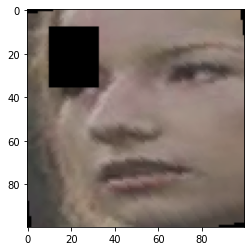

In [28]:
trans_img = transform_images[random_idx]
ctrl_img = images[random_idx]
plt.imshow(trans_img)

In [43]:
from collections import OrderedDict

In [44]:
LABELS = OrderedDict(
    {
        -1: "No prediction",
        0: "Surprise",
        1: "Fear",
        2: "Disgust",
        3: "Happiness",
        4: "Sadness",
        5: "Anger",
        6: "Neutral",
    }
)

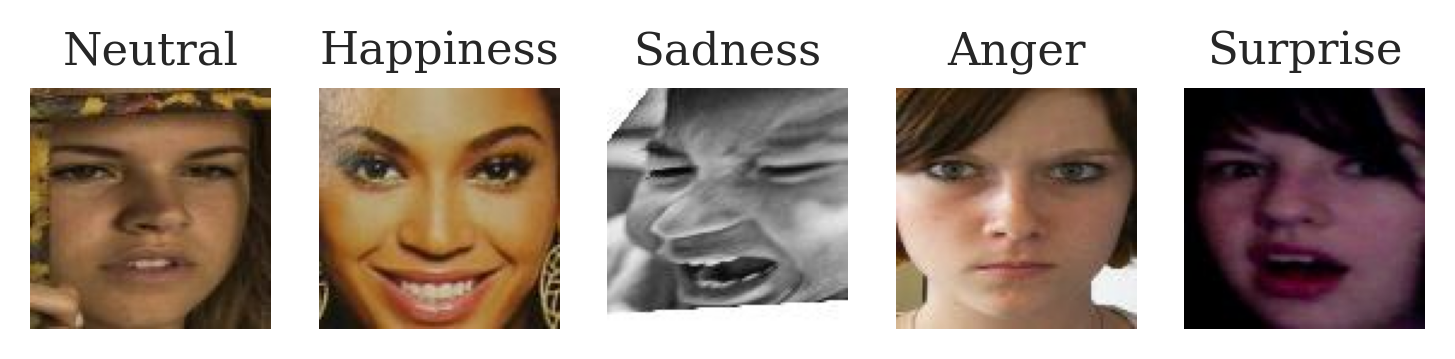

In [121]:

img_labels = list(zip(images, labels))

fig, axes = plt.subplots(1,5, dpi=300)

for i, ((img, label), ax) in enumerate(zip(img_labels[:5], axes.ravel())):
    
    rand_idx = random.choice(list(range(len(img_labels))))
    
    ax.imshow(img_labels[rand_idx][0])
    ax.set_title(LABELS.get(img_labels[rand_idx][1]))
    ax.set_axis_off()
    

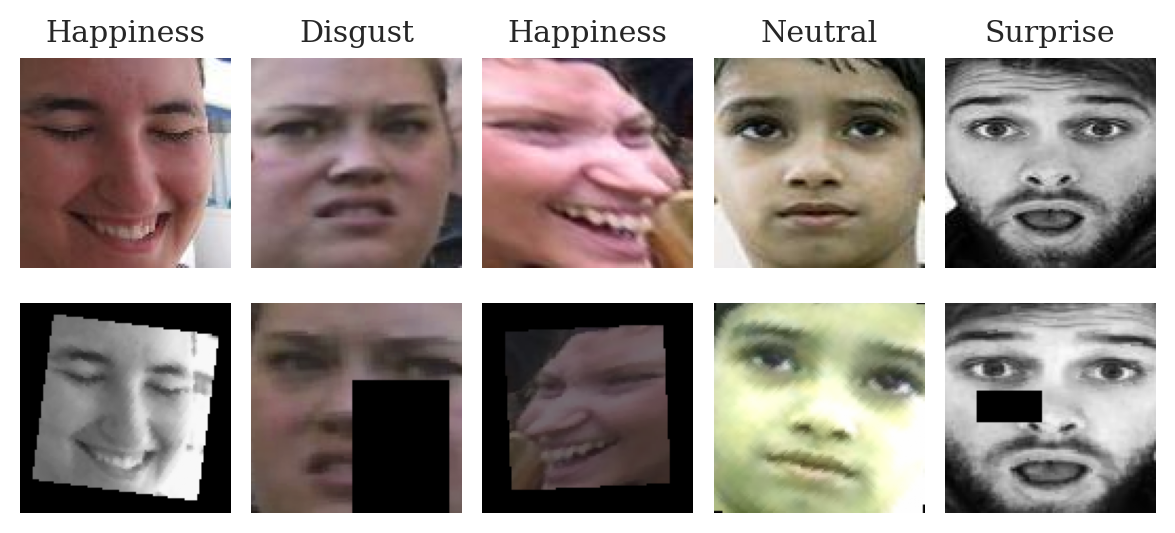

In [188]:
img_labels = list(zip(images, labels))
trans_img_labels = list(zip(transform_images, transform_images))


fig, axes = plt.subplots(2,5, dpi=200)


for i, ((img, label)) in enumerate(img_labels[:5]):
    
    rand_idx = random.choice(list(range(len(img_labels))))
    axes[0][i].imshow(img_labels[rand_idx][0])
    axes[1][i].imshow(trans_img_labels[rand_idx][0])
    axes[0][i].set_title(LABELS.get(img_labels[rand_idx][1]))
    axes[1][i].set_aspect('equal')
    axes[0][i].set_aspect('equal')
    axes[0][i].set_axis_off()
    axes[1][i].set_axis_off()
    
fig.tight_layout()
plt.subplots_adjust(wspace=.10, hspace=-0.50)

In [238]:
label_array = [LABELS.get(x) for x in labels]

In [239]:
import pandas as pd

In [241]:
label_counts = pd.DataFrame(pd.DataFrame(label_array).value_counts())


In [248]:
label_counts.columns = ['count']
label_counts = label_counts.reset_index()

In [250]:
label_counts.columns = ['emotion', 'count']

In [253]:
label_counts['pct'] = label_counts['count'] / (label_counts['count'].sum())* 100

In [280]:
label_counts

,emotion,count,pct
0,Happiness,3817,38.885493
1,Neutral,2019,20.568460
2,Sadness,1585,16.147107
3,Surprise,1032,10.513447
4,Disgust,574,5.847596
5,Anger,564,5.745721
6,Fear,225,2.292176


In [270]:
import matplotlib

<ipython-input-279-c271479be749>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(label_counts['emotion'], fontdict={'fontsize':12})


Text(0.5, 1.0, 'Class Distribution of RAF Dataset')

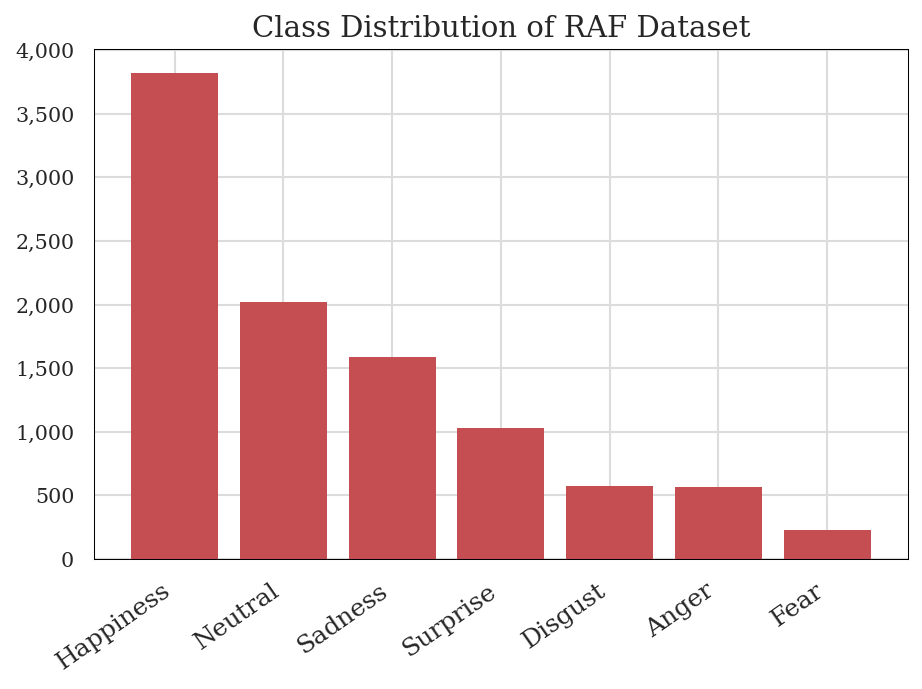

In [279]:
fig, ax = plt.subplots(figsize=(7, 5), dpi=150)

ax.bar(label_counts['emotion'], label_counts['count'], color='r');
fig.autofmt_xdate(rotation=35)
ax.set_xticklabels(label_counts['emotion'], fontdict={'fontsize':12})
ax.get_yaxis().set_major_formatter(
matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.set_title('Class Distribution of RAF Dataset', fontdict={'fontsize': 14})

In [285]:
HOG_des = feature.hog(
    img,
    orientations=16,
    pixels_per_cell=(4,4),
    cells_per_block=(1,1),
    feature_vector=True,
    multichannel=True
)

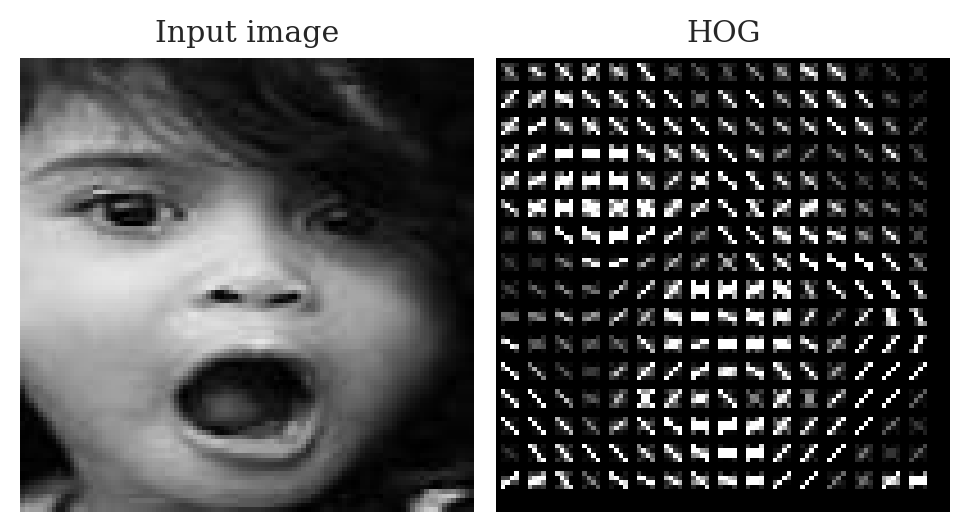

In [483]:
fd, hog_image = feature.hog(img, orientations=8, pixels_per_cell=(6, 6),
                    cells_per_block=(3, 3), visualize=True, multichannel=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 6), sharex=True, sharey=True, dpi=200)

img = images[400]

ax1.axis('off')
ax1.imshow(img, cmap=plt.cm.gray)
ax1.set_title('Input image')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('HOG')
plt.subplots_adjust(wspace=.05, hspace=-0.50)
plt.show()

### Create a SIFT Visualisation 

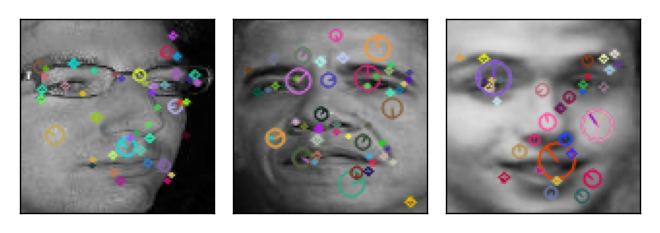

In [462]:
fig, axes = plt.subplots(1,3, figsize=(4,4), dpi=200)

for ax in axes.ravel():
    
    img = np.array(images[random.choice(range(len(images)))])
    gray= cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    sift = cv2.SIFT_create()
    kp = sift.detect(gray,None)
    img=cv2.drawKeypoints(gray,kp,img, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)   
    ax.imshow(img)
    ax.grid(False)
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    plt.subplots_adjust(wspace=.10, hspace=-0.50)

In [5]:
from test import EmotionRecognition

In [6]:
import os

In [7]:
em = EmotionRecognition(test_path=os.path.join(DATASET_DIR,  "test"), model_type="SVM")
preds, metrics = em.predict()

INFO:test:Making predictions on test data
INFO:test:Loading test data for all images
INFO:utils:Successfully loaded 3068 images
INFO:utils:Beginning clustering process for 3066 images
100%|██████████| 3066/3066 [00:01<00:00, 1723.44it/s]
c:\users\brenner\documents\python_projects\emotion_recognition\venv\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [10]:
import pandas as pd

In [11]:
lr_data = pd.read_csv('../old_logs/run-CNN_2021-04-29 10-11-tag-Learning Rate.csv')

Text(0.5, 1.0, 'CNN Cyclic Learning Rate')

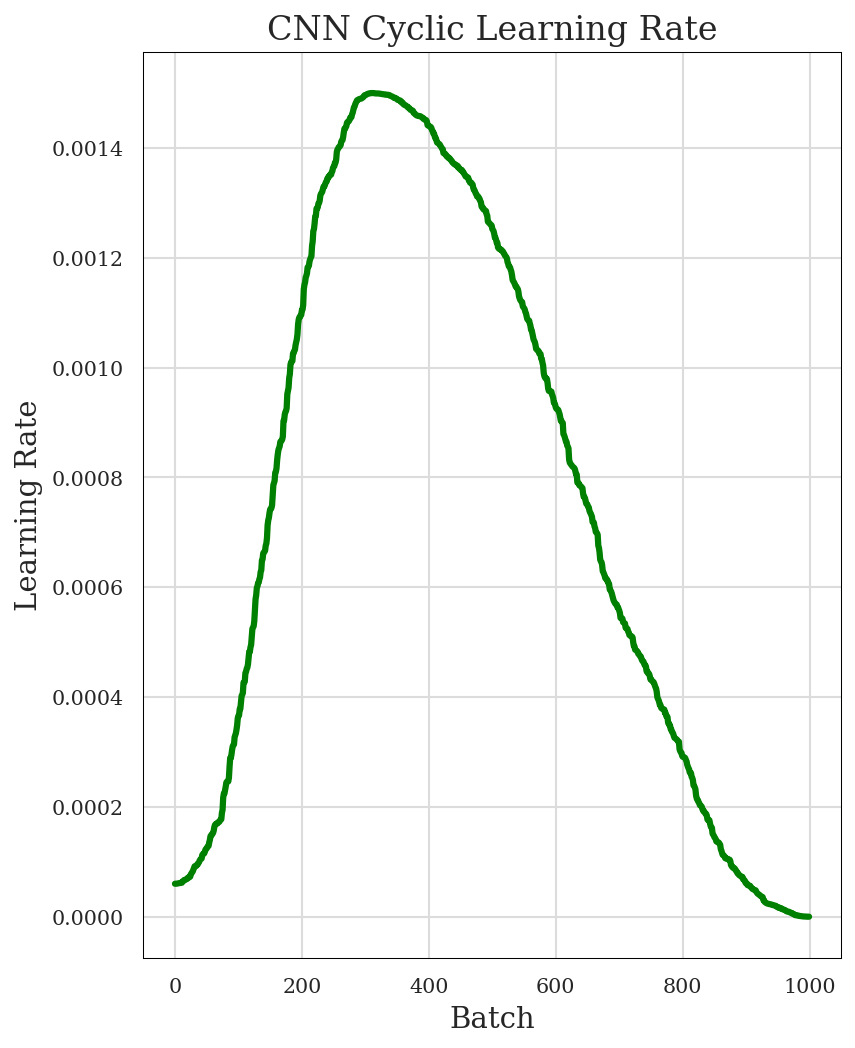

In [28]:
fig, ax = plt.subplots(figsize=(6,8), dpi=150)

ax.set_xlabel('Batch', fontdict={'fontsize': 14})
ax.set_ylabel('Learning Rate', fontdict={'fontsize': 14})
ax.plot(lr_data['Value'], lw=3, color='green')
ax.set_title('CNN Cyclic Learning Rate', fontsize=16)

In [52]:
val_data = pd.read_csv('../old_logs/run-CNN_2021-04-29 10-11-tag-Validation Accuracy.csv').rename(columns={'Value': 'Validation Accuracy'})

In [53]:
val_loss = pd.read_csv('../old_logs/run-CNN_2021-04-29 10-11-tag-Loss_Validation.csv').rename(columns={'Value': 'Validation Loss'})

In [54]:
val_data = val_data.merge(val_loss[['Step', 'Validation Loss']], on="Step", how='left')

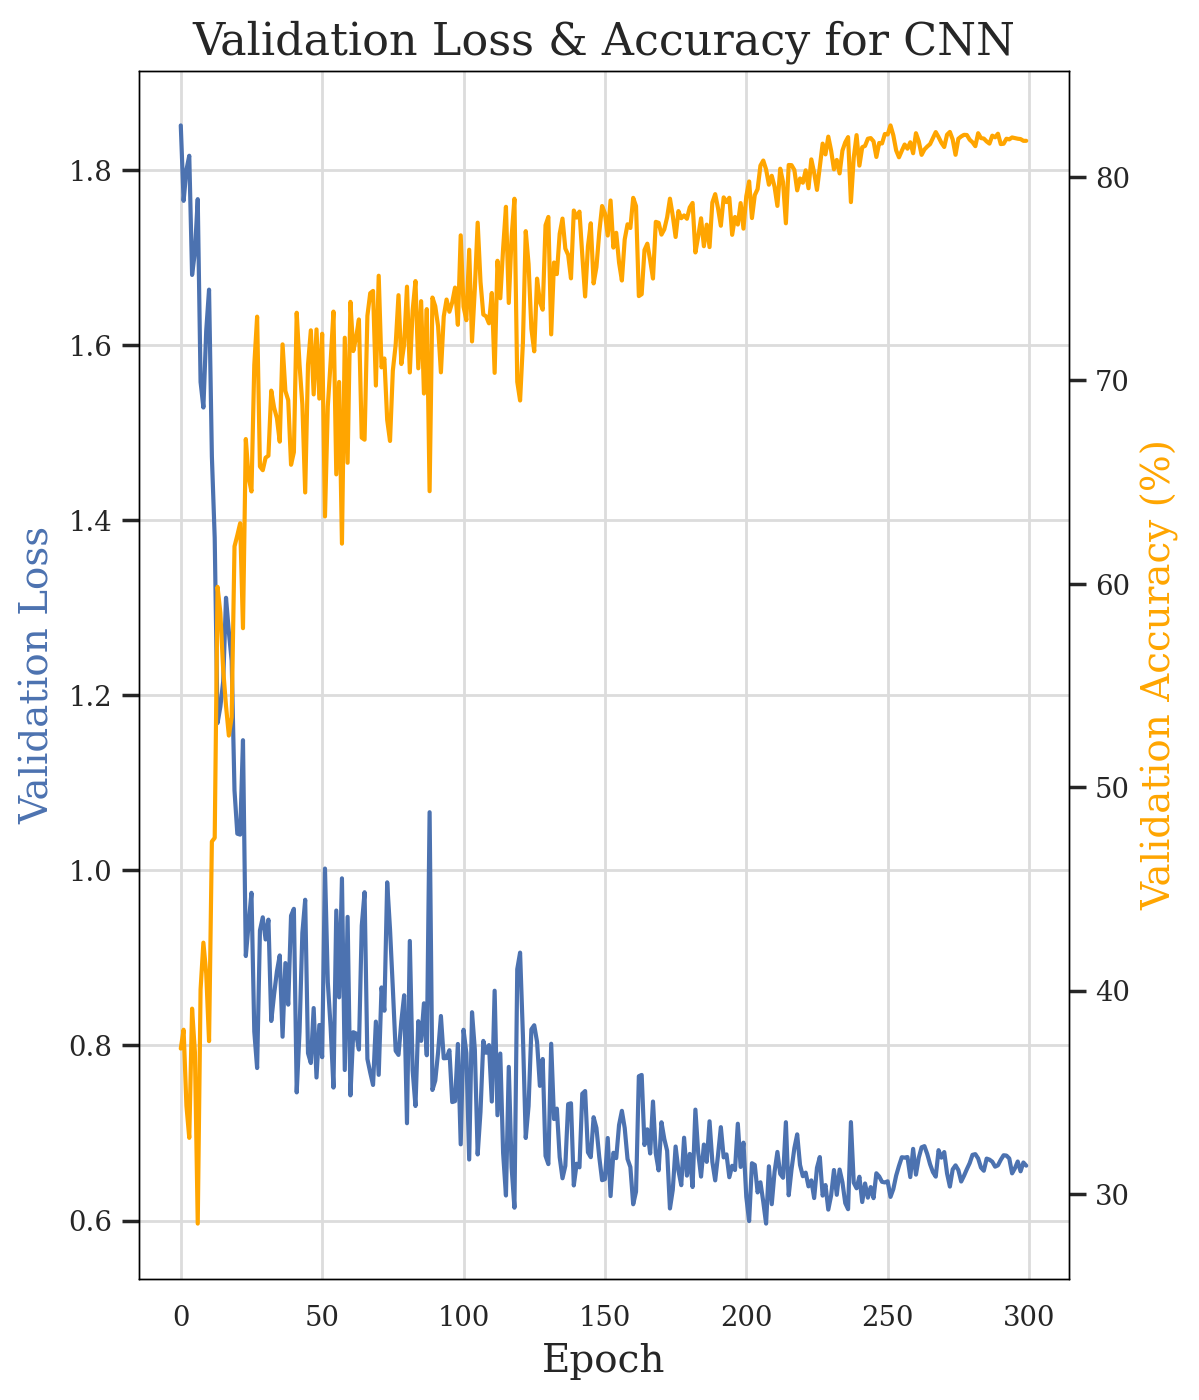

In [63]:

fig, ax = plt.subplots(figsize=(6, 8), dpi=200)
ax.set_xlabel("Epoch", fontdict={'fontsize': 14})
ax.plot(val_data['Validation Loss'], color="b")
ax.set_ylabel("Validation Loss", color="b", fontdict={'fontsize': 14})
ax2 = ax.twinx()
ax2.set_ylabel("Validation Accuracy (%)", color="orange", fontdict={'fontsize': 14})
ax2.plot(val_data['Validation Accuracy'], color="orange")
ax.set_title("Validation Loss & Accuracy for CNN", fontsize=16)
ax2.grid()